In [1]:
# Cell 1: Install dependencies (if needed)
!pip install requests pandas geopandas matplotlib contextily dateutil pytz


ERROR: Could not find a version that satisfies the requirement dateutil (from versions: none)
ERROR: No matching distribution found for dateutil

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Cell 2: Import libraries
import requests
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
import pytz # New import for timezone awareness
import logging # For consistent logging as in ETL

In [ ]:
# Cell 3: Fetch OBIS observations for a demo query (edit `geometry` and `class` as needed)
# Example: Marine species in a North Atlantic bounding box
OBIS_API_ENDPOINT = "https://api.obis.org/v3/occurrence"
params = {
    "geometry": "POLYGON((-80 30, -80 50, -30 50, -30 30, -80 30))",  # Example bounding box (long/lat)
    "classid": "1239",  # Replace with the actual class id you're interested in
    "size": 500  # Number of results (OBIS default max: 500)
}
response = requests.get(OBIS_API_ENDPOINT, params=params)
data = response.json()["results"]
print(f"Fetched {len(data)} records.")

Fetched 500 records.


In [3]:
# Set up a basic logger for the notebook
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# Avoid duplicating handlers if the cell is run multiple times
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(levelname)s: %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

# OBIS API parameters
OBIS_API_ENDPOINT = "https://api.obis.org/v3/occurrence"
params = {
    "geometry": "POLYGON((-80 30, -80 50, -30 50, -30 30, -80 30))",  # Example bounding box (long/lat)
    "size": 100  # OBIS default max: 500
}

In [4]:
# Cell 2: Fetch OBIS occurrences
# This cell remains mostly the same, ensuring robust API call
logger.info(f"Fetching OBIS data from {OBIS_API_ENDPOINT} with params: {params}")
try:
    response = requests.get(OBIS_API_ENDPOINT, params=params, timeout=30)
    response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
    obis_results = response.json().get("results", [])
    logger.info(f"Fetched {len(obis_results)} OBIS records.")
except requests.exceptions.RequestException as e:
    logger.error(f"OBIS API request failed: {e}")
    obis_results = []
except ValueError as e: # Catch JSONDecodeError specifically for older python versions, or general ValueError
    logger.error(f"Failed to decode JSON response from OBIS API: {e}")
    obis_results = []


INFO: Fetching OBIS data from https://api.obis.org/v3/occurrence with params: {'geometry': 'POLYGON((-80 30, -80 50, -30 50, -30 30, -80 30))', 'size': 100}
INFO: Fetched 100 OBIS records.


In [5]:
# Cell 3: Helper function: Fetch common name from WoRMS (adapted for robustness)
def get_common_name_from_worms(aphia_id):
    if not aphia_id:
        return None
    worms_url = f"https://www.marinespecies.org/rest/AphiaVernacularsByAphiaID/{aphia_id}"
    try:
        r = requests.get(worms_url, timeout=5)
        r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        data = r.json()
        if data:  # list of common names
            # pick the preferred one or the first English one
            preferred = next((d for d in data if d.get("isPreferredName") == 1), None)
            if preferred:
                return preferred.get("vernacular")
            english = next((d for d in data if d.get("language") == 'English'), None)
            if english:
                return english.get("vernacular")
            return data[0].get("vernacular")
        return None
    except requests.exceptions.RequestException as e:
        logger.warning(f"WoRMS API request failed for AphiaID {aphia_id}: {e}")
        return None
    except ValueError as e: # Specific for JSONDecodeError, or general ValueError
        logger.warning(f"Failed to decode JSON response from WoRMS API for AphiaID {aphia_id}: {e}")
        return None
    except Exception as e:
        logger.warning(f"Unexpected error fetching common name for AphiaID {aphia_id}: {e}")
        return None

In [6]:
# Cell 4: Process and Combine OBIS + WoRMS (adapted for ETL cleaning rules - maximize observations)

enriched_data = []

for i, obs in enumerate(obis_results):
    # Basic data integrity checks before processing
    obis_id = obs.get("id")
    if not obis_id:
        logger.warning(f"Record {i}: OBIS record missing 'id' field, record will be appended but 'obis_id' will be None.")
        # We will still append the record as per your goal, but note the issue.

    lon = obs.get("decimalLongitude")
    lat = obs.get("decimalLatitude")
    if lon is None or lat is None:
        logger.warning(f"Record {i} (OBIS ID: {obis_id}): Missing coordinates, 'location' will be None.")
        location_point = None
    else:
        try:
            location_point = Point(float(lon), float(lat))
        except ValueError as e:
            logger.warning(f"Record {i} (OBIS ID: {obis_id}): Invalid coordinate format ({lon}, {lat}), 'location' will be None. Error: {e}")
            location_point = None
        except Exception as e:
            logger.warning(f"Record {i} (OBIS ID: {obis_id}): Unexpected error processing coordinates, 'location' will be None. Error: {e}")
            location_point = None

    aphia_id = obs.get("aphiaID")
    common_name = get_common_name_from_worms(aphia_id) # This function handles its own logging/warnings

    # Date Parsing with Timezone Awareness - Maximize Observations
    event_date_str = obs.get("eventDate")
    observation_datetime = None
    observation_date = None

    if event_date_str: # Only attempt to parse if the string exists
        try:
            dt_obj = parser.parse(event_date_str)
            if dt_obj.tzinfo is None or dt_obj.tzinfo.utcoffset(dt_obj) is None:
                observation_datetime = pytz.utc.localize(dt_obj)
            else:
                observation_datetime = dt_obj.astimezone(pytz.utc)
            observation_date = observation_datetime.date()
        except ValueError as ve:
            logger.warning(f"Record {i} (OBIS ID: {obis_id}): 'eventDate' '{event_date_str}' could not be parsed. Date/time fields set to None. Error: {ve}")
        except Exception as e:
            logger.warning(f"Record {i} (OBIS ID: {obis_id}): Unexpected error parsing 'eventDate' '{event_date_str}'. Date/time fields set to None. Error: {e}")
    else:
        logger.debug(f"Record {i} (OBIS ID: {obis_id}): No 'eventDate' string. Date/time fields will be None.")

    # Other fields, ensuring proper types or defaults
    depth = obs.get("bathymetry")
    try:
        depth = float(depth) if depth is not None else None
    except (TypeError, ValueError):
        logger.warning(f"Record {i} (OBIS ID: {obis_id}): Invalid 'bathymetry' value '{depth}', depth set to None.")
        depth = None

    temperature = obs.get("sst")
    try:
        temperature = float(temperature) if temperature is not None else None
    except (TypeError, ValueError):
        logger.warning(f"Record {i} (OBIS ID: {obis_id}): Invalid 'sst' value '{temperature}', temperature set to None.")
        temperature = None


    record = {
        "obis_id": obis_id, # Ensure obis_id is explicitly set here
        "species_name": obs.get("scientificName") or "Unknown species",
        "common_name": common_name,
        "location": location_point,
        "observation_datetime": observation_datetime,
        "observation_date": observation_date, # Add observation_date explicitly
        "location_name": obs.get("datasetName") or "OBIS record",
        "depth": depth,
        "temperature": temperature,
        "visibility": None,  # OBIS doesn’t provide visibility
        "notes": f"Imported from OBIS dataset: {obs.get('datasetName') or 'Unknown'}",
        "image": None, # OBIS doesn't provide direct image URLs
        "machine_observation": obs.get("basisOfRecord"),
        "validated": "validated", # Assuming this is a default from your ETL
        "source": "obis",
        "user": None, # Assuming user is not available from OBIS
        "raw_data": obs, # Keep the original raw data
    }

    enriched_data.append(record)
    # Be kind to the API, but for a notebook, you might adjust or remove this if fetching locally
    # sleep(0.2)

logger.info(f"Finished processing. Total records in enriched_data: {len(enriched_data)}")
print("\nFirst 5 enriched records (showing problematic fields as None):")
for rec in enriched_data[:5]:
    print(rec)

INFO: Finished processing. Total records in enriched_data: 100



First 5 enriched records (showing problematic fields as None):
{'obis_id': '00000099-0f3b-4118-bc57-1cac9e27f56e', 'species_name': 'Myoxocephalus octodecemspinosus', 'common_name': 'longhorn sculpin', 'location': <POINT (-59.163 43.768)>, 'observation_datetime': datetime.datetime(2014, 8, 1, 4, 14, tzinfo=<UTC>), 'observation_date': datetime.date(2014, 8, 1), 'location_name': 'MARITIMES SUMMER RESEARCH VESSEL SURVEY', 'depth': 134.0, 'temperature': 9.64, 'visibility': None, 'notes': 'Imported from OBIS dataset: MARITIMES SUMMER RESEARCH VESSEL SURVEY', 'image': None, 'machine_observation': 'HumanObservation', 'validated': 'validated', 'source': 'obis', 'user': None, 'raw_data': {'basisOfRecord': 'HumanObservation', 'brackish': True, 'class': 'Teleostei', 'classid': 293496, 'datasetName': 'MARITIMES SUMMER RESEARCH VESSEL SURVEY', 'date_end': 1406851200000, 'date_mid': 1406851200000, 'date_start': 1406851200000, 'date_year': 2014, 'decimalLatitude': 43.7685, 'decimalLongitude': -59.163

In [9]:
# Cell 5: Analyze Common Name Coverage

if not enriched_data:
    logger.info("No data in 'enriched_data' to analyze common name coverage.")
else:
    total_records = len(enriched_data)
    records_with_common_name = 0

    for record in enriched_data:
        if record.get("common_name") is not None:
            records_with_common_name += 1

    common_name_coverage = (records_with_common_name / total_records) * 100 if total_records > 0 else 0

    logger.info("\n--- Common Name Coverage Analysis ---")
    logger.info(f"Total records processed: {total_records}")
    logger.info(f"Records with a common name: {records_with_common_name}")
    logger.info(f"Common name coverage: {common_name_coverage:.2f}%")

    if common_name_coverage < 100:
        logger.warning(f"Note: {total_records - records_with_common_name} records are missing a common name.")

INFO: 
--- Common Name Coverage Analysis ---
INFO: Total records processed: 100
INFO: Records with a common name: 89
INFO: Common name coverage: 89.00%


In [16]:
# Cell 4: Load data into a DataFrame and clean up
df = pd.DataFrame(enriched_data)
# df = df[df["decimalLongitude"].notnull() & df["decimalLatitude"].notnull()]
df.head()

,obis_id,species_name,common_name,location,observation_datetime,observation_date,location_name,depth,temperature,visibility,notes,image,machine_observation,validated,source,user,raw_data
0,00000099-0f3b-4118-bc57-1cac9e27f56e,Myoxocephalus octodecemspinosus,longhorn sculpin,POINT (-59.163333 43.7685),2014-08-01 04:14:00+00:00,2014-08-01,MARITIMES SUMMER RESEARCH VESSEL SURVEY,134.0,9.64,None,Imported from OBIS dataset: MARITIMES SUMMER R...,None,HumanObservation,validated,obis,None,"{'basisOfRecord': 'HumanObservation', 'brackis..."
1,00000289-be25-40f1-b3b1-d983c7641d9d,Leucosolenia,branching ball-sponge,POINT (-76.1211090088 33.006111145),1985-09-22 12:00:00+00:00,1985-09-22,OBIS record,1986.0,25.94,None,Imported from OBIS dataset: Unknown,None,PreservedSpecimen,validated,obis,None,{'associatedReferences': 'National Museum of N...
2,000002dd-fba5-4166-ae49-54c3104a7e62,Metridia longa,None,POINT (-68.627166748 48.7083282471),2010-06-03 17:52:12+00:00,2010-06-03,OBIS record,164.0,5.20,None,Imported from OBIS dataset: Unknown,None,HumanObservation,validated,obis,None,"{'basisOfRecord': 'HumanObservation', 'brackis..."
3,0000034b-6563-4b62-aa0a-74ad00f8602f,Morus bassanus,gannet,POINT (-79.0351 33.3883),2018-12-18 08:34:15+00:00,2018-12-18,Ecological Baseline Studies of the U.S. Outer ...,11.0,22.21,None,Imported from OBIS dataset: Ecological Baselin...,None,HumanObservation,validated,obis,None,"{'associatedReferences': '[{""crossref"":{""citei..."
4,0000066e-455a-430e-9987-e24fbc16b039,Perca flavescens,yellow perch,POINT (-79.5166666667 44.25),1952-08-16 12:00:00+00:00,1952-08-16,OBIS record,-216.0,NaN,None,Imported from OBIS dataset: Unknown,None,HumanObservation,validated,obis,None,"{'basisOfRecord': 'HumanObservation', 'brackis..."


In [13]:
def harmonize_observation_type(observation_type):
    if isinstance(observation_type, str):
        # Convert to lowercase for consistent processing
        normalized_type = observation_type.lower()

        # Handle specific cases where words are concatenated and need to be split
        replacements = {
            'humanobservation': 'human observation',
            'machineobservation': 'machine observation',
            'materialsample': 'material sample',
            'nomenclaturalchecklist': 'nomenclatural checklist',
            'preservedspecimen': 'preserved specimen',
            'occurrence': 'occurrence' # already good, but for completeness
        }

        for old, new in replacements.items():
            normalized_type = normalized_type.replace(old, new)

        # Capitalize the first letter of each word
        return normalized_type.title()
    return observation_type

df['machine_observation'] = df['machine_observation'].apply(harmonize_observation_type)

print(df['machine_observation'].unique())

['Human Observation' 'Preserved Specimen' 'Machine Observation'
 'Occurrence' 'Material_Sample' 'Nomenclatural Checklist']


In [11]:
# Cell 5: Create a GeoDataFrame for geospatial analysis
geometry = [Point(xy) for xy in zip(df["decimalLongitude"], df["decimalLatitude"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf.head()

KeyError: 'decimalLongitude'

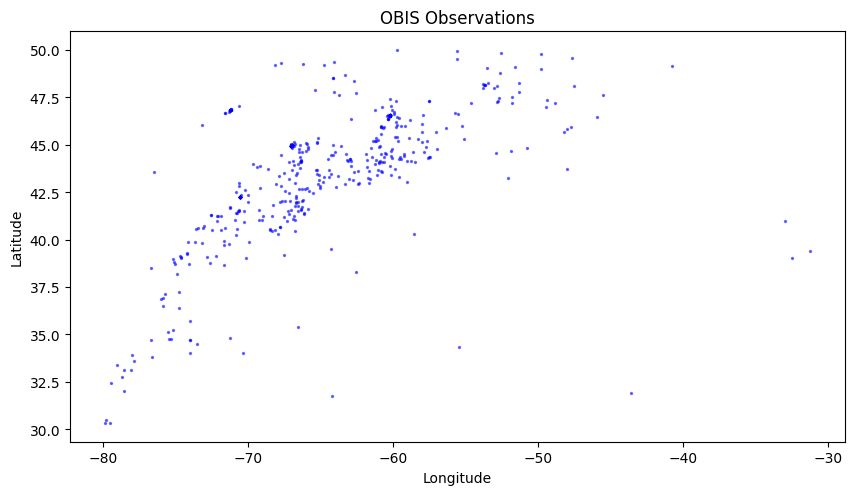

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, marker='o', color='blue', markersize=2, alpha=0.5)
plt.title("OBIS Observations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

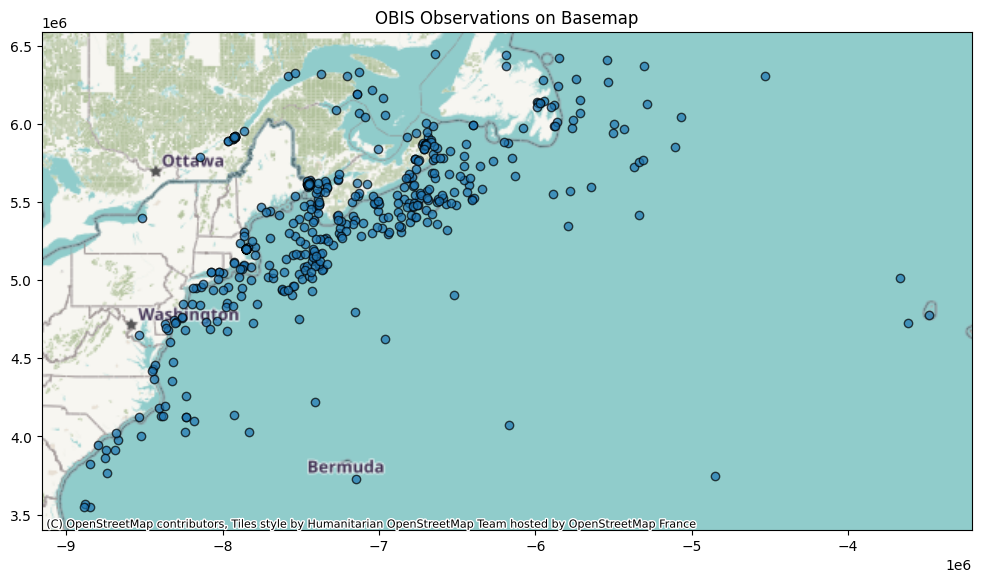

In [18]:
# Convert to web mercator
gdf_webmerc = gdf.to_crs(epsg=3857)

ax = gdf_webmerc.plot(figsize=(12, 8), alpha=0.7, edgecolor="k")
ctx.add_basemap(ax, crs=gdf_webmerc.crs)
plt.title("OBIS Observations on Basemap")
plt.show()

In [19]:
# Cell 7: Example — Filter data (e.g., by date or species name)
recent = gdf[gdf["eventDate"] > "2023-01-01"]
print(f"Recent records: {len(recent)}")
recent[["scientificName", "eventDate", "decimalLongitude", "decimalLatitude"]].head()

Recent records: 14


,scientificName,eventDate,decimalLongitude,decimalLatitude
32,Morone saxatilis,2024-06-10 10:01:07,-62.909350,46.348300
36,Cetacea,6/21/2011,-58.846666,45.353333
55,Huso fulvescens,2023-10-01 21:00:50,-71.132250,46.872330
65,Larus argentatus,NA,-70.116670,39.033330
92,Phocoena phocoena,8/29/1999,-66.389166,44.346666
